## Figuring out how to train SLAYER model using VAE method developed with Decolle and torchneuromorphic
### The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. For full training, use standard nmnist dataloaders 

## Load proper paths for SLAYER Pytorch source modules¶

In [1]:
import sys, os  

CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "slayerPytorch/src")

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load required modules
* SLAYER modules are available as `snn`.{`layer`, `params`, `loss`, `predict`, `io`}
* SLAYER-Loihi module implements `spikeLayer` (defines custom Loihi neuron behaviour) and `quantizeWeights` (defines weight quantization scheme)
* Optimizer implements custom NADAM optimizer

In [3]:
from torchneuromorphic import transforms
import importlib
from tqdm import tqdm
from torch import nn
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
import slayerSNN.auto 
from slayerSNN import loihi as spikeLayer
from slayerSNN import quantize as quantizeParams
from slayerSNN import learningStats as learningStats
from slayerSNN import optimizer as optimizer
# from slayerLoihi import spikeLayer
# from quantizeParams import quantizeWeights
# from learningStats import learningStats
# import optimizer
import zipfile

In [4]:
from torchvision.utils import make_grid

## Define function for converting events to time surfaces

In [5]:
def generate_process_target(aug_epoch=0):
    tau1 = 1/(1-0.97)
    tau2 = 1/(1-0.92)
    print(transforms.ToCountFrame)
    t1 = transforms.ExpFilterEvents(tau=tau2, length = int(6*tau2), tpad=int(6*tau2), device='cuda' )    
    t2 = transforms.ExpFilterEvents(tau=tau1, length = int(6*tau1), tpad=int(6*tau1), device='cuda' )
    if aug_epoch<1:
        filter_data = transforms.Compose([t1, t2, transforms.Rescale(50.)])
    else:
        filter_data = transforms.Compose([t1, t2, transforms.Rescale(50.), transforms.Jitter()])

    def process_target(data, aug_epoch=0):
        l = data.shape[1]
        if aug_epoch > 0:
            jitter_data = transforms.Compose([filter_data, transforms.Jitter(xs=1,ys=1,th=5)])
            return jitter_data(data)[:,l]
        return filter_data(data)[:,l]
    
    return filter_data, process_target

filter_data, process_target = generate_process_target()

<class 'torchneuromorphic.transforms.ToCountFrame'>


## To use torchneuromorphic data with SLAYER
SLAYER formats torch.Size([12, 2, 34, 34, 350]) i.e. (batch,p,x,y,t)

This is different from torchneuromorphic format which uses torch.Size([12, 350, 2, 32, 32]) (batch,p,t,x,y) format (not sure if the order of x and y is correct)

Therefore, to use torchneuromorphic with SLAYER, need to transpose along the correct dimensions to make the data usable by SLAYER type models

## Dataset Definition
The dataset definition follows standard PyTorch dataset definition. Internally, it utilizes `snn.io` modules to read spikes and returns the spike in correct tensor format (`CHWT`).
* `datasetPath`: the path where the spike files are stored.
* `sampleFile`: the file that contains a list of sample indices and its corresponding clases.
* `samplingTime`: the sampling time (in ms) to bin the spikes.
* `sampleLength`: the length of the sample (in ms)

Note: This is a simple dataset class. A dataset that utilizes the folder hierarchy or xml list is easy to create just like any other PyTorch dataset definition.

In [6]:
# Define the cuda device to run the code on.
device = torch.device('cuda')

In [7]:
root_nmnist = 'data/dvsgesture/dvs_gestures.hdf5'

dataset = importlib.import_module('torchneuromorphic.dvs_gestures.dvsgestures_dataloaders')
try:
    create_data = dataset.create_data
except AttributeError:
    create_data = dataset.create_dataloader

In [8]:
train_dl, test_dl = create_data(root=root_nmnist,
                                  chunk_size_train=200,#1450,
                                  chunk_size_test=200,#1450,
                                  batch_size=100,#params['batch_size'],
                                  dt=1000,#params['deltat'],
                                  num_workers=12,
                                ds=4,
                               time_shuffle=True)#params['num_dl_workers'])

In [9]:
data_batch, target_batch = next(iter(train_dl))

data_batch = data_batch[target_batch[:,-1,:].argmax(1)!=10]

data_batch = torch.Tensor(data_batch).to(device)
target_batch = torch.Tensor(target_batch).to(device)

In [10]:
print(data_batch.shape)

torch.Size([92, 200, 2, 32, 32])


In [11]:
print(target_batch.shape)

torch.Size([100, 200, 11])


In [12]:
def transpose_torchneuromorphic_to_SLAYER(data_batch):
    data_batch = torch.transpose(data_batch, 1,2)
    data_batch = torch.transpose(data_batch,2,3)
    data_batch = torch.transpose(data_batch,3,4)
    # it looks like torchneuromorphic does y,x so switch them
    data_batch = torch.transpose(data_batch,2,3)
    return data_batch

In [13]:
data_batch_transposed = transpose_torchneuromorphic_to_SLAYER(data_batch)

In [14]:
def batch_one_hot(targets, num_classes=10):
    one_hot = torch.zeros((targets.shape[0],num_classes))
    #print("targets shape", targets.shape)
    for i in range(targets.shape[0]):
        one_hot[i][targets[i]] = 1
        
    return one_hot

In [15]:
def three_unsqueeze(target_batch):
    # use torch.unsqueeze to make slayer compatible with current error calculation.
    # will probably want to use different error calculation method to conform to what I did in decolle
    # but let's just get this working for now
    target_batch = torch.unsqueeze(target_batch,-1)
    target_batch = torch.unsqueeze(target_batch,-1)
    target_batch = torch.unsqueeze(target_batch,-1)
    
    return target_batch

## Describe the network
Network is a standard VAE using an encoder and then a decoder.
Because the goal is to put it on the Loihi, everything will need to use
SLAYER with its Loihi simulator.
In the decolle implementation we did not use spiking encoder head or classifiers,
so I'm really hoping this will work ok using spikes...

In [16]:
netDesc = {
    'simulation' : {'Ts': 1, 'tSample': 300},#1450},
    'neuron' : {
        'type'     : 'LOIHI',
        'vThMant'  : 80,#40,#80,
        'vDecay'   : 128,
        'iDecay'   : 1024,
        'refDelay' : 1,
        'wgtExp'   : 0,
        'tauRho'   : 1,
        'scaleRho' : 1024,#1024, # sumit said adjusting this could help with vanishing gradients. Loihi uses 128-1024
    },
#     'layer' : [
#         {'dim' : '32x32x2'},
#         {'dim' : 512},
#         {'dim' : 512},
#         {'dim' : 10}, 
#     ],
    'training' : {
        'error' : {
            'type' : 'NumSpikes',
            'tgtSpikeRegion': {'start': 0, 'stop': 1450},    # only valid for NumSpikes and ProbSpikes
        'tgtSpikeCount': {'true': 180, 'false': 30},  # only valid for NumSpikes
        }
    }
}

netParams = snn.params(dict=netDesc)

In [17]:
headNetDesc = {
    'simulation' : {'Ts': 1, 'tSample': 300},#1450},
    'neuron' : {
        'type'     : 'LOIHI',
        'vThMant'  : 80,#40,#80,
        'vDecay'   : 3072,#4096,
        'iDecay'   : 1024,
        'refDelay' : 1,
        'wgtExp'   : 0,
        'tauRho'   : 1,
        'scaleRho' : 1024,#1024, # sumit said adjusting this could help with vanishing gradients. Loihi uses 128-1024
    },
#     'layer' : [
#         {'dim' : '32x32x2'},
#         {'dim' : 512},
#         {'dim' : 512},
#         {'dim' : 10}, 
#     ],
    'training' : {
        'error' : {
            'type' : 'NumSpikes',
            'tgtSpikeRegion': {'start': 0, 'stop': 1450},    # only valid for NumSpikes and ProbSpikes
        'tgtSpikeCount': {'true': 180, 'false': 30},  # only valid for NumSpikes
        }
    }
}

headNetParams = snn.params(dict=headNetDesc)

In [18]:
class Encoder(torch.nn.Module):
    def __init__(self, netParams):
        # since gradients are having trouble flowing through net
        # maybe too big?
        # try reducing layers and see if that works or something
        super(Encoder, self).__init__()
        # initialize slayer
        slayer = spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        
        # define network functions
        # Encoder
        self.conv1 = slayer.conv(2, 16, 5, padding=2, weightScale=10) # in, out, kernel, padding. 
        self.conv2 = slayer.conv(16, 32, 3, padding=1, weightScale=50)
        self.pool1 = slayer.pool(1)
        self.pool2 = slayer.pool(2)
        self.pool3 = slayer.pool(2)
        self.fc1   = slayer.dense((8*8*32), 512)
        self.fc2   = slayer.dense(512, 128)
        
        self.drop  = slayer.dropout(0.1)

    def forward(self, spikeInput):
        # because of torchneuromorphic, don't need first pooling layer, probably
        spike = self.slayer.spikeLoihi(self.pool1(spikeInput )) # 32, 32, 2
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        #spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.conv1(spike)) # 32, 32, 16
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.pool2(spike)) # 16, 16, 16
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.conv2(spike)) # 16, 16, 32
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.pool3(spike)) #  8,  8, 32
        spike = spike.reshape((spike.shape[0], -1, 1, 1, spike.shape[-1]))
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.fc1  (spike)) # 512
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.fc2  (spike)) # 11
#         with torch.no_grad():
#             print(torch.sum(spike))
        spike = self.slayer.delayShift(spike, 1)
    
        return spike
    
    # mean and variance layer (encoder head)
    # for beta=0 set leak term to max (voltage decay)
    # try fp logvar

In [20]:
class EncoderHead(torch.nn.Module):
    def __init__(self, netParams):
        # since gradients are having trouble flowing through net
        # maybe too big?
        # try reducing layers and see if that works or something
        super(EncoderHead, self).__init__()
        # initialize slayer
        slayer = spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        
        self.fc_mu   = slayer.dense(128, 100) 
        self.fc_logvar = slayer.dense(128,100)
    
    def forward(self, spikeInput):
        
        # put spiking encoder head, that will give mu logvar
    # as spike rates. THese will be trained. Then the reparameterized
    # z can be clustered, hopefully, on loihi. hell yeah let's gooooo
        mu_spike = self.slayer.spikeLoihi( self.fc_mu(spikeInput))
        with torch.no_grad():
            print(torch.sum(mu_spike))
        #mu_spike = self.slayer.delayShift(mu_spike, 1)
        logvar_spike = self.slayer.spikeLoihi( self.fc_logvar(spikeInput))
        #logvar_spike = self.slayer.delayShift(logvar_spike, 1)
        with torch.no_grad():
            print(torch.sum(logvar_spike))
        
        return mu_spike , logvar_spike
    
    # evaluate viability of using voltage for disentanglement
    def get_voltage(self, spikeInput):
        
        spike, current, mu_voltage = self.slayer.spikeLoihiFull(self.fc_mu(spikeInput))
        
        spike, current, logvar_voltage = self.slayer.spikeLoihiFull(self.fc_logvar(spikeInput))
        
        return mu_voltage, logvar_voltage
    
    # meta sugur figures: log normal, get rid of labels for figs

In [21]:
# For the rest of the VAE parts, in decolle I defined these parts using pytorch and they were not spiking
# this can be fine for initial testing, but if I want to put the encoder on loihi then I need
# to have the encoder_head and excitation classifier to be spiking
# not really sure how this would even work, it's kind of a glaring flaw that I somehow didn't see until now
# I guess I can see what kind of output a SLAYER encoder_head would produce, but then reparameterizing is a mystery
# or just use something that converts ANN to SNN and hope it's okay...

In [22]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class VAE(torch.nn.Module):
    def __init__(self, netParams,headParams,error,out_features=128,dimz=100,ngf=16,num_classes=10):
        super(VAE, self).__init__()
        
        self.dimz=dimz
        self.error = error
        
        self.encoder = Encoder(netParams)
        self.encoder_head = EncoderHead(headParams)
        
        
#         # non spiking encoder_head. This won't work on Loihi.
#         self.encoder_head = nn.ModuleDict({'mu':nn.Linear(out_features, dimz), 
#                                        'logvar':nn.Linear(out_features, dimz)})
        # initialize encoder_head
#         for l in self.encoder_head:
#             #print(self.encoder_head[l])
#             if isinstance(self.encoder_head[l], nn.Linear):
#                 torch.nn.init.normal_(self.encoder_head[l].weight)
                #print("init")
                
        # this is a pytorch decoder, non spiking. It's ok if this part is non spiking
        # autograd should handle it
        self.decoder = nn.Sequential(
                    nn.Linear(dimz, out_features),
                    Reshape(-1,out_features,1,1),
                    nn.ConvTranspose2d(out_features, ngf * 8, 4, 2, 0, bias=False),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * 2,     2, 4, 2, 1, bias=False),
                    nn.ReLU())
        
        #self.init_parameters()
        
        from collections import OrderedDict
        layer_size = 100
        layer_size2 = 100 #300
        layer_size3 = 100 #400
        self.cls_sq = nn.Sequential(
            OrderedDict([
                ('lin1', nn.Linear(num_classes,layer_size)),
                ('norm1', nn.BatchNorm1d(layer_size)),
                ('relu1', nn.LeakyReLU(negative_slope=0.2,inplace=True)),
                ('lin2', nn.Linear(layer_size,layer_size2)),
                ('norm2', nn.BatchNorm1d(layer_size2)),
                ('relu2', nn.LeakyReLU(negative_slope=0.2,inplace=True)),
                ('lin4', nn.Linear(layer_size3, num_classes))
            ])
        )
        
        # init model weights
        for l in self.cls_sq:
            if isinstance(l, nn.Linear):
                torch.nn.init.kaiming_uniform_(l.weight, nonlinearity='leaky_relu')

   # def init_parameters(self):
     #   self.encoder_head['logvar'].weight.data[:] *= 1e-16
     #   self.encoder_head['logvar'].bias.data[:] *= 1e-16 
     #   return 
    
    def encode(self, x):
        spike = self.encoder(x)
#         spike = error.slayerPSP(spike)
        
#         kernel = self.encoder.slayer.srmKernel
#         maxKernel = torch.max(kernel).detach()
#         spike = spike/maxKernel
        
        # input into encoder_head
        mu_spike, logvar_spike = self.encoder_head(spike)
        mu_spike = self.error.slayerPSP(mu_spike) # post synaptic potential
        logvar_spike = self.error.slayerPSP(logvar_spike)
        kernel = self.encoder_head.slayer.srmKernel
        maxKernel = torch.max(kernel).detach()
        mu_spike = mu_spike/maxKernel
        logvar_spike = logvar_spike/maxKernel

        #print(mu_spike)
        
        mu_spike = torch.squeeze(mu_spike,2)
        mu_spike = torch.squeeze(mu_spike,2)
        #mu_voltage = torch.mean(mu_voltage,2) 
        mu_spike = torch.transpose(mu_spike,0,2)
        mu_spike = torch.transpose(mu_spike,1,2)
        mu_spike = mu_spike[-1]
        
        logvar_spike = torch.squeeze(logvar_spike,2)
        logvar_spike = torch.squeeze(logvar_spike,2)
        #logvar_spike = torch.mean(logvar_spike,2) 
        logvar_spike = torch.transpose(logvar_spike,0,2)
        logvar_spike = torch.transpose(logvar_spike,1,2)
        logvar_spike = logvar_spike[-1]
        
        #print(type(mu))
        #rint(mu_voltage
        
        #h1 = torch.nn.functional.leaky_relu(spike) 
        # need to get membrane potential from mu and logvar instead of spieks
        return mu_spike, logvar_spike
    
    # see if voltage is usable for encoding. it might not be...
    def encode_voltage(self, x):
        spike = self.encoder(x)
        
        mu_voltage, logvar_voltage = self.encoder_head.get_voltage(spike)
        
        mu_voltage = torch.squeeze(mu_voltage,2)
        mu_voltage = torch.squeeze(mu_voltage,2)
        #mu_voltage = torch.mean(mu_voltage,2) 
        mu_voltage = torch.transpose(mu_voltage,0,2)
        mu_voltage = torch.transpose(mu_voltage,1,2)
        mu_voltage = mu_voltage[-1]
        
        logvar_voltage = torch.squeeze(logvar_voltage,2)
        logvar_voltage = torch.squeeze(logvar_voltage,2)
        #logvar_spike = torch.mean(logvar_spike,2) 
        logvar_voltage = torch.transpose(logvar_voltage,0,2)
        logvar_voltage = torch.transpose(logvar_voltage,1,2)
        logvar_voltage = logvar_voltage[-1]
        
        return mu_voltage, logvar_voltage
        
        
    # for reparameterizing mu and logvar output by encoder_head
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)
    
    def excite_z(self,z,num_classes=10):
        exc_z = torch.zeros((z.shape[0],num_classes))
        for i in range(z.shape[0]):
            exc_z[i] = z[i,:num_classes]#[t[i]]
        
        return exc_z

    def forward(self, x):
        mu, logvar = self.encode(x)
       # print(mu) # to see what mu is like
        #logvar = torch.zeros(mu.shape).cuda()
        #logvar = torch.ones(mu.shape).cuda()
        #with torch.no_grad():
        #    print(mu)
        #    print(logvar)
        z = self.reparameterize(mu, logvar)
        clas = self.cls_sq(self.excite_z(z,10).cuda())
        return self.decode(z), mu, logvar, clas
    
    def z_voltage(self, x):
        mu_voltage, logvar_voltage = self.encode_voltage(x)
        
        z = mu_voltage #self.reparameterize(mu_voltage, logvar_voltage)
        clas = self.cls_sq(self.excite_z(z,10).cuda())
        return self.decode(z), mu_voltage, logvar_voltage, clas

In [23]:
#print(net.encoder.slayer.srmKernel)

In [24]:
class InhibNet(nn.Module):
    def __init__(self, dimz, num_classes, hidden_layers):
        super(InhibNet, self).__init__()
        
        input_size = dimz-num_classes
            
        output_size = num_classes

        self.num_classes = num_classes

        self.model = nn.Sequential(hidden_layers)
        
        # init model weights
        for l in self.model:
            if isinstance(l, nn.Linear):
                torch.nn.init.kaiming_uniform_(l.weight, nonlinearity='leaky_relu')
                
    def forward(self, x):
        x=self.model(x)
        return x
        

    def excite_z(self,z):
        exc_z = torch.zeros((z.shape[0],self.num_classes))
    
        for i in range(z.shape[0]):
            exc_z[i] = z[i,:self.num_classes]#[t[i]]
        
        return exc_z

    def inhibit_z(self,z):
        inhib_z = torch.zeros((z.shape[0], z.shape[1]-self.num_classes))
    
        for i in range(z.shape[0]):
            inhib_z[i] = z[i,self.num_classes:]
        
        return inhib_z

In [25]:
out_features = 128
dimz = 100
ngf = 16

In [26]:
from collections import OrderedDict
layer_size = 100
inhib_layers = OrderedDict([
        ('lin1', nn.Linear(dimz-10,layer_size)),
        ('norm1', nn.BatchNorm1d(layer_size)),
        ('relu1', nn.LeakyReLU(negative_slope=0.2,inplace=True)),
        ('lin2', nn.Linear(layer_size,layer_size)),
        ('norm2', nn.BatchNorm1d(layer_size)),
        ('relu2', nn.LeakyReLU(negative_slope=0.2,inplace=True)),
        #('droput',nn.Dropout(0.05)),
        ('lin3', nn.Linear(layer_size, 10))#,
        #('soft', nn.LogSoftmax(dim=1))#nn.LogSoftmax(dim=1))
    ])

In [27]:
class InhibNet(nn.Module):
    def __init__(self, dimz, num_classes, hidden_layers):
        super(InhibNet, self).__init__()
        
        input_size = dimz-num_classes
            
        output_size = num_classes

        self.num_classes = num_classes

        self.model = nn.Sequential(hidden_layers)
        
        # init model weights
        for l in self.model:
            if isinstance(l, nn.Linear):
                torch.nn.init.kaiming_uniform_(l.weight, nonlinearity='leaky_relu')
                
    def forward(self, x):
        x=self.model(x)
        return x
        

    def excite_z(self,z):
        exc_z = torch.zeros((z.shape[0],self.num_classes))
    
        for i in range(z.shape[0]):
            exc_z[i] = z[i,:self.num_classes]#[t[i]]
        
        return exc_z

    def inhibit_z(self,z):
        inhib_z = torch.zeros((z.shape[0], z.shape[1]-self.num_classes))
    
        for i in range(z.shape[0]):
            inhib_z[i] = z[i,self.num_classes:]
        
        return inhib_z

In [28]:
from collections import OrderedDict
layer_size = 100
inhib_layers = OrderedDict([
        ('lin1', nn.Linear(dimz-10,layer_size)),
        ('norm1', nn.BatchNorm1d(layer_size)),
        ('relu1', nn.LeakyReLU(negative_slope=0.2,inplace=True)),
        ('lin2', nn.Linear(layer_size,layer_size)),
        ('norm2', nn.BatchNorm1d(layer_size)),
        ('relu2', nn.LeakyReLU(negative_slope=0.2,inplace=True)),
        #('droput',nn.Dropout(0.05)),
        ('lin3', nn.Linear(layer_size, 10))#,
        #('soft', nn.LogSoftmax(dim=1))#nn.LogSoftmax(dim=1))
    ])

In [29]:
inhib = InhibNet(dimz,10,inhib_layers).cuda()

In [30]:
def vae_loss_fn(recon_x, x, mu, logvar, vae_beta = 4.0):
    # not sure how well this will work with SLAYER, if at all, or if special modifications will need to be made
    llhood = torch.nn.functional.mse_loss(recon_x, x)
    #negKLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)/len(train_dl)
    #print(llhood,kld_loss)
    return llhood + vae_beta*kld_loss

In [31]:
def guided_vae_loss_fn(recon_x, x, mu, logvar, excite_loss, inhib_loss, vae_beta = 4.0):
    llhood = torch.nn.functional.mse_loss(recon_x, x)
    #negKLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())                                                                                                                                                                       
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)/len(train_dl)
    return llhood+vae_beta*kld_loss+(excite_loss-inhib_loss)

In [32]:
criterion = nn.MultiLabelSoftMarginLoss(reduction='sum') 

## Initialize the network
* Define the device to run the code on.
* Create network instance.
* Create loss instance.
* Define optimizer module.
* Define training and testing dataloader.
* Cereate instance for learningStats.

In [33]:
from decolle.utils import MultiOpt
from itertools import chain

In [34]:
# Create snn loss instance.
error = snn.loss(netParams, snn.loihi).to(device)
headError = snn.loss(headNetParams, snn.loihi).to(device)
# Create network instance.
#net = snn.auto.loihi.Network(netParams).to(device)
net = VAE(netParams,headNetParams,headError).to(device)

calculating Loihi psp
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
calculating Loihi psp
Max PSP kernel: 64.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
calculating Loihi psp
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
calculating Loihi psp
Max PSP kernel: 64.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


In [38]:
# Define optimizer module.
opt1 = torch.optim.Adamax(net.encoder.parameters(), lr = 0.000001,betas=[0,0.95],eps=1e-4) #snn.utils.optim.Nadam(net.encoder.parameters(), lr = 0.0003, amsgrad = True) # lr=0.0003

opt2 = torch.optim.Adam(chain(*[net.encoder_head.parameters(),net.decoder.parameters()]), lr=0.000001) #snn.utils.optim.Nadam(chain(*[net.encoder_head.parameters(),net.decoder.parameters()]), lr=0.0003) # lr=0.0003

opt_excititory = torch.optim.Adam(net.cls_sq.parameters(), lr=0.000001) # lr=0.0001

opt_inhibitory = torch.optim.Adam(inhib.model.parameters(), lr=0.000001) # lr=0.0001

opt = MultiOpt(opt1, opt2, opt_excititory, opt_inhibitory)

# Learning stats instance.
stats = snn.utils.stats()

## Train the network
* Best network is stored for inferencing later


## Guided VAE

In [39]:
from utils import save_checkpoint, load_model_from_checkpoint
starting_epoch=0

### Training Loop

In [40]:
# for loading a model from checkpoint
starting_epoch = load_model_from_checkpoint('loihi_sim_model', net, opt, inhib, n_checkpoint=-1)

Resuming from epoch 631


In [41]:
# Guided VAE training with SLAYER
# The decolle vae quickly achieves decent accuracy(50% after 5 epochs) with decent reconstructions
# the slayer vae seems to be quickly converging to 16% accuracy and has uniform blob reconstructions
# the architecture should be the same between both. Is it the neuron and surrogate gradient differences? 
# or some parameter needs changing? maybe network is not good for slayer, idk
# or maybe too much noise in the data?
losses = []

for epoch in range(5001):
    tSt = datetime.now()
    print(epoch)
    # Training loop.
    # use torchneuromophic dataloaders for training
    sum_vae_loss = 0
    for x,t in tqdm(iter(train_dl)):
        net.train()
        
        inhib.train()
        
        # Reset gradients to zero.
        opt.zero_grad()
        
        new_t = t[t[:,-1,:].argmax(1)!=10]
#         if new_t.shape[0] < 2:
#             #print(new_t.shape)
#             continue
        new_t = new_t[:,-1,:].argmax(1)
        #print(new_t.shape)
        x = x[t[:,-1,:].argmax(1)!=10]
        
        #print("t shape", new_t.shape)
        
        
        x_c = x.to(device)
        # get time surface for reconstruction
        frames = process_target(x_c)#torch.transpose(x_c,3,4)) # make sure the image is not sideways
        
        # process target and input to make SLAYER compatible
        x_c = transpose_torchneuromorphic_to_SLAYER(x_c)
        
        
        hot_ts = batch_one_hot(new_t, num_classes=10)
        
        # Forward pass of the network.
        y,mu,logvar,clas = net(x_c)
        
        #print(y.shape)
        #print(frames.shape)
        
        loss = vae_loss_fn(y, frames, mu, logvar, vae_beta=1.2)
        
        clas_loss = criterion(clas, hot_ts.to(device))
        
        vae_loss = loss
        
        loss += clas_loss
        loss.backward()
        
#         print("net grads first pass")
        with torch.no_grad():
            print("encoder")
            print(net.encoder.conv1.weight.grad.abs().mean())
            print(net.encoder.conv2.weight.grad.abs().mean())
#             print(net.encoder.conv3.weight.grad.abs().mean())
#             #print(net.encoder.conv4.weight.grad.abs().mean())
            print(net.encoder.fc1.weight.grad.abs().mean())
#             print(net.encoder.mu.weight.grad.abs().mean())
#             print(net.encoder.logvar.weight.grad.abs().mean())
            #print(net.encoder.fc2.weight.grad.abs().mean())
            print("encoder_head")

            print(net.encoder_head.fc_mu.weight.grad.abs().mean())
            print(net.encoder_head.fc_logvar.weight.grad.abs().mean())
            print("classifier last")
            print(net.cls_sq.lin4.weight.grad.abs().mean())
        
        opt.step()
        opt.zero_grad()
        
        z = net.reparameterize(mu,logvar).detach()
        inhib_z = inhib.inhibit_z(z)
        
        excite_output = inhib.model(inhib_z.to(device))
        loss = criterion(excite_output, hot_ts.to(device))
        excite_loss = loss 
        loss.backward()
        
        opt.step()
        
        opt.zero_grad()
        #mu, logvar = net.encode(x_c)
        mu, logvar = net.encode(x_c)
        #logvar = torch.zeros(mu.shape).cuda()
        z = net.reparameterize(mu, logvar)
        inhib_z = inhib.inhibit_z(z)
        inhib_output= inhib.model(inhib_z.to(device))
        
        inhib_hot_ts = torch.empty_like(hot_ts).fill_(0.5)
        loss = criterion(inhib_output, inhib_hot_ts.to(device))
        
        inhib_loss = loss
        loss.backward()
        
        opt.step()

        # Gather the training stats.
#         stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
#         stats.training.numSamples     += len(label)

        # Calculate loss. 
        #loss = error.numSpikes(output, t) # spikeLoss.py

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats. (Suitable for normal python implementation)
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
        
        sum_vae_loss+=vae_loss.detach().cpu()
    print(sum_vae_loss/12)
    losses.append(sum_vae_loss/12)

    # save the model for future use/training
    #if epoch%10==0: # start saving every 10 bc memory
    save_checkpoint(epoch+starting_epoch+1, 'Trained2/guided_vae', net, opt, inhib)
    
    # save the weights to look at them and make sure they are quantizing or not or whatever
#     for name, param in net.named_parameters():
#         print(name, param.shape)
#         np.save(f'Trained2/grads/{name}.npy',param.detach().cpu().numpy())
        
   
     #   np.save(f'Trained2/grads/{l.name}.npy',param.weight.grad.detach().cpu().numpy())


#     # Update testing stats.
#     if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
#     stats.update()  
#     if stats.training.bestLoss is True: torch.save(net.state_dict(), 'Trained/nmnistNet.pt')

0


  0%|                                                                                                                                                                                                                 | 0/12 [00:00<?, ?it/s]

tensor(58007., device='cuda:0')
tensor(1748., device='cuda:0')
encoder
tensor(0.0011, device='cuda:0')
tensor(0.0011, device='cuda:0')
tensor(0.0002, device='cuda:0')
encoder_head
tensor(0.0003, device='cuda:0')
tensor(5.7996e-05, device='cuda:0')
classifier last
tensor(0.1429, device='cuda:0')


  0%|                                                                                                                                                                                                                 | 0/12 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(losses)    
    
save_checkpoint(epoch+starting_epoch+1, 'Trained2/guided_vae', net, opt, inhib)
starting_epoch = epoch+starting_epoch

In [ ]:
#starting_epoch = load_model_from_checkpoint('Trained2/guided_vae', net, opt, inhib, n_checkpoint=-1)

### Plot reconstructions, check accuracy, tsne projections for model evaluation

In [ ]:
orig = process_target(data_batch).detach().cpu().view(*[[-1]+[2,32,32]])[:,0:1]
print(orig.shape)
figure2 = plt.figure(99)
plt.imshow(make_grid(orig, scale_each=True, normalize=True).transpose(0,2).numpy())

In [ ]:
recon_batch,mu,logvar,clas = net(data_batch_transposed.to(device))

In [ ]:
# try voltage, it might go terribly
recon_batch,mu,logvar,clas = net.z_voltage(data_batch_transposed.to(device))

In [ ]:
recon_batch_c = recon_batch.detach().cpu()
figure = plt.figure()
img = recon_batch_c.view(*[[-1]+[2,32,32]])[:,0:1]
print(img.shape) 
plt.imshow(make_grid(img, scale_each=True, normalize=True).transpose(0,2).numpy())

# TSNE Projections to Evaluate Disentanglement

In [42]:
def get_latent_train(dl, net, iterations=1):
    #all_d = []
    lats = []
    tgts = []

    for x,t in tqdm(iter(dl)):#,l,u in tqdm(iter(dl)): 
        
        new_t = t[t[:,-1,:].argmax(1)!=10]
#         if new_t.shape[0] < 2:
#             #print(new_t.shape)
#             continue
        new_t = new_t[:,-1,:].argmax(1)
        #print(new_t.shape)
        x = x[t[:,-1,:].argmax(1)!=10]
        #print(new_t.shape)
         # process target and input to make SLAYER compatible
        x = transpose_torchneuromorphic_to_SLAYER(x)

        with torch.no_grad():
            mu, logvar = net.encode(x.to(device))
            #logvar = torch.ones(mu.shape).to(device)
            lat = net.reparameterize(mu,logvar).detach().cpu().numpy()
            lats += lat.tolist()
            tgts += new_t.tolist()

                #all_d += process_target(x).tolist()
    return np.array(lats), np.array(tgts)#[:,-1,:].argmax(1)

In [43]:
def get_latent_voltage(dl, net):
    lats = []
    tgts = []

    for x,t in tqdm(iter(dl)):#,l,u in tqdm(iter(dl)): 
        
        new_t = t[t[:,-1,:].argmax(1)!=10]
#         if new_t.shape[0] < 2:
#             #print(new_t.shape)
#             continue
        new_t = new_t[:,-1,:].argmax(1)
        #print(new_t.shape)
        x = x[t[:,-1,:].argmax(1)!=10]
        #print(new_t.shape)
         # process target and input to make SLAYER compatible
        x = transpose_torchneuromorphic_to_SLAYER(x)

        with torch.no_grad():
            mu, logvar = net.encode_voltage(x.to(device))
            #logvar = torch.ones(mu.shape).to(device)
            lat = mu.detach().cpu().numpy() #net.reparameterize(mu,logvar).detach().cpu().numpy()
            lats += lat.tolist()
            tgts += new_t.tolist()

                #all_d += process_target(x).tolist()
    return np.array(lats), np.array(tgts)#[:,-1,:].argmax(1)

In [44]:
def tsne_project(lats, tgts, net, do_plot = True):
    from sklearn.manifold import TSNE
    #print(lats.shape)
    lat_tsne = TSNE(n_components=2).fit_transform(lats)
    inhib_tsne = TSNE(n_components=2).fit_transform(net.inhibit_z(torch.from_numpy(lats)).numpy())
    exc_tsne = TSNE(n_components=2).fit_transform(net.excite_z(torch.from_numpy(lats)).numpy())
    #tgts = tgts[:10]
    if do_plot:
        fig = plt.figure(figsize=(16,10))
        fig4 = plt.figure(figsize=(16,10))
        fig5 = plt.figure(figsize=(16,10))
        ax = fig.add_subplot()
        ax4 = fig4.add_subplot()
        ax5 = fig5.add_subplot()
        
        for i in range(10):#1):
            idx = tgts==i
            ax.scatter(lat_tsne[idx,0],lat_tsne[idx,1], label = dataset.mapping[i])
            ax4.scatter(exc_tsne[idx,0],exc_tsne[idx,1], label = dataset.mapping[i])
            ax5.scatter(inhib_tsne[idx,0],inhib_tsne[idx,1], label = dataset.mapping[i])
        ax.legend()
        ax4.legend()
        ax5.legend()
        
        return lat_tsne, fig, fig4, fig5
    else:
        return lat_tsne

In [45]:
def eval_accuracy(lats, tgts, excite, net):
    correct_count, all_count = 0, 0
    
    zs = excite.excite_z(torch.from_numpy(lats))

    net.eval()
    print(zs.shape)
    for i in range(len(tgts)):
        net.eval()
        with torch.no_grad():
            logps = net(torch.unsqueeze(zs[i],0).to(device)) # was net.model(...)
        ps = torch.exp(logps.cuda())
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = tgts[i]#.numpy()[i]
        #print(true_label)
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
    return correct_count/all_count

In [46]:
lats, tgts = get_latent_train(train_dl, net, iterations=1)

  8%|████████████████▊                                                                                                                                                                                        | 1/12 [00:01<00:12,  1.16s/it]

tensor(56445., device='cuda:0')
tensor(1219., device='cuda:0')


 17%|█████████████████████████████████▌                                                                                                                                                                       | 2/12 [00:01<00:09,  1.02it/s]

tensor(52645., device='cuda:0')
tensor(1228., device='cuda:0')


 25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 3/12 [00:02<00:07,  1.14it/s]

tensor(58868., device='cuda:0')
tensor(1511., device='cuda:0')


 33%|███████████████████████████████████████████████████████████████████                                                                                                                                      | 4/12 [00:02<00:06,  1.25it/s]

tensor(57587., device='cuda:0')
tensor(1286., device='cuda:0')


 42%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 5/12 [00:03<00:05,  1.36it/s]

tensor(58888., device='cuda:0')
tensor(1589., device='cuda:0')


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 6/12 [00:04<00:04,  1.43it/s]

tensor(58708., device='cuda:0')
tensor(1286., device='cuda:0')


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 7/12 [00:04<00:03,  1.50it/s]

tensor(57007., device='cuda:0')
tensor(1489., device='cuda:0')


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 8/12 [00:05<00:02,  1.54it/s]

tensor(59868., device='cuda:0')
tensor(1411., device='cuda:0')


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 9/12 [00:05<00:01,  1.61it/s]

tensor(55285., device='cuda:0')
tensor(1296., device='cuda:0')


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 10/12 [00:06<00:01,  1.63it/s]

tensor(54960., device='cuda:0')
tensor(1292., device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 11/12 [00:07<00:00,  1.62it/s]

tensor(63425., device='cuda:0')
tensor(1608., device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.56it/s]

tensor(40813., device='cuda:0')
tensor(1133., device='cuda:0')


In [47]:
print(lats.shape)

(1078, 100)


In [48]:
lats_test, tgts_test = get_latent_train(test_dl, net, iterations=1)

 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1/3 [00:01<00:02,  1.17s/it]

tensor(65898., device='cuda:0')
tensor(882., device='cuda:0')


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2/3 [00:01<00:00,  1.00it/s]

tensor(72809., device='cuda:0')
tensor(2519., device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]

tensor(50772., device='cuda:0')
tensor(959., device='cuda:0')


In [49]:
train_acc = eval_accuracy(lats, tgts, inhib, net.cls_sq)

torch.Size([1078, 10])


In [50]:
print(train_acc)

0.5204081632653061


In [51]:
test_acc = eval_accuracy(lats_test, tgts_test, inhib, net.cls_sq)

torch.Size([264, 10])


In [52]:
print(test_acc)

0.45075757575757575


In [55]:
print(dataset.mapping)

{0: 'Hand Clapping', 1: 'Right Hand Wave', 2: 'Left Hand Wave', 3: 'Right Arm CW', 4: 'Right Arm CCW', 5: 'Left Arm CW', 6: 'Left Arm CCW', 7: 'Arm Roll', 8: 'Air Drums', 9: 'Air Guitar', 10: 'Other'}


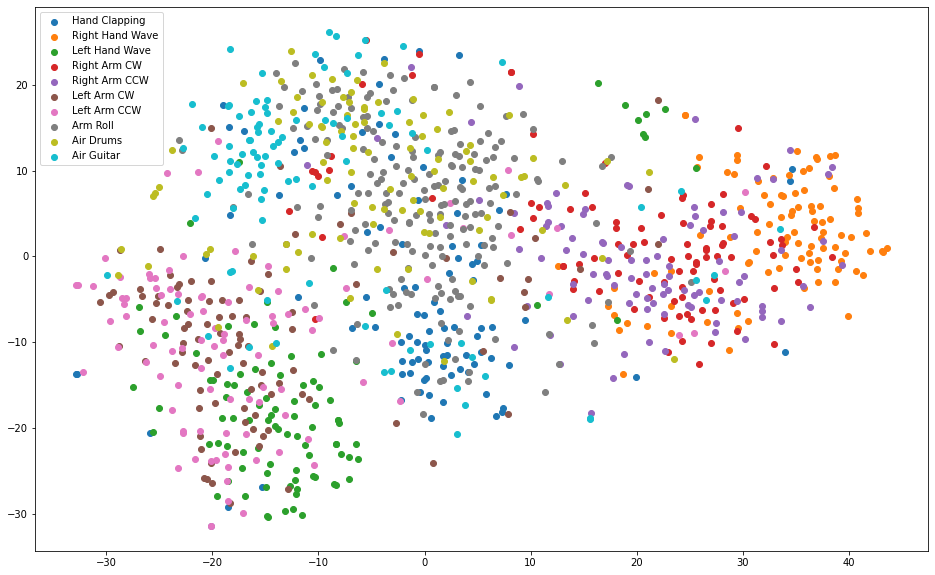

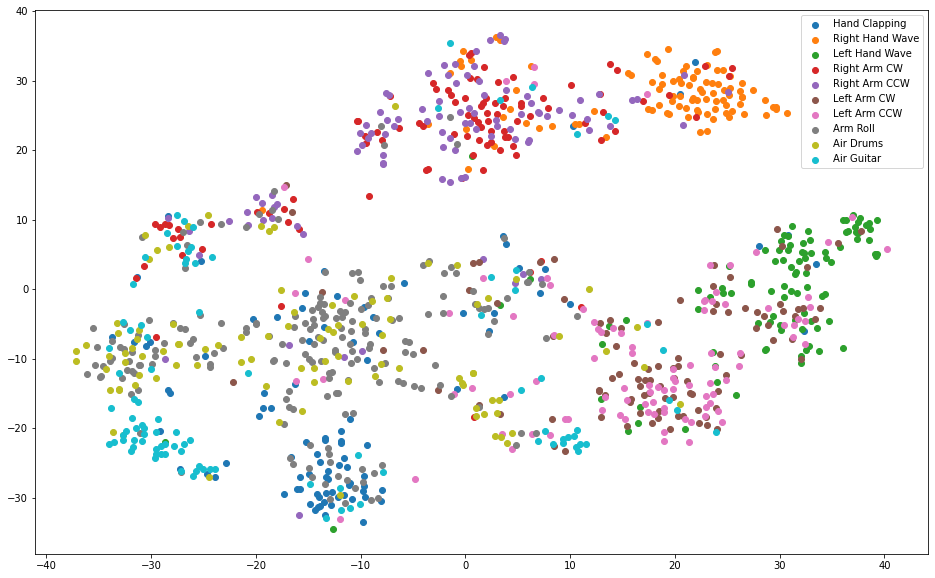

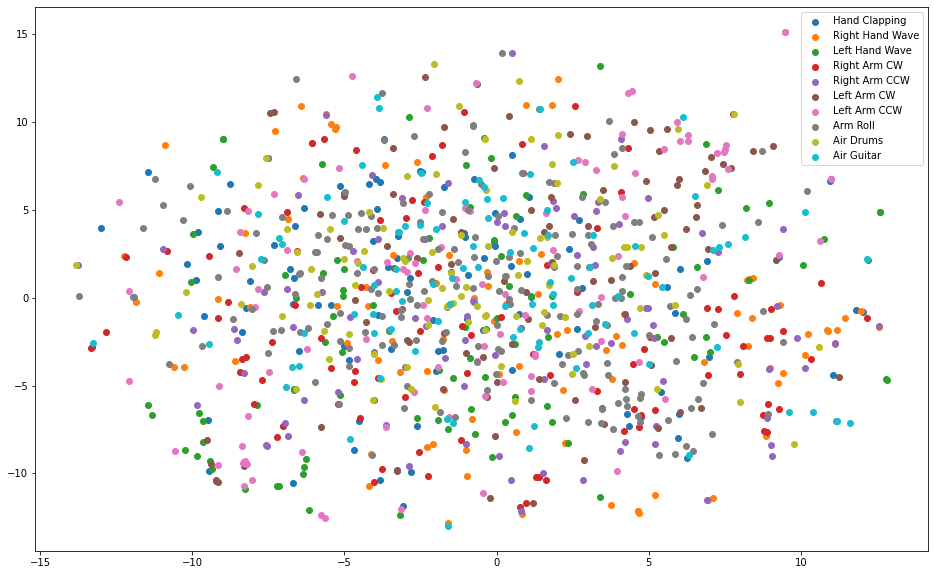

In [56]:
lat_tsne, fig, fig4, fig5 = tsne_project(lats, tgts, inhib)

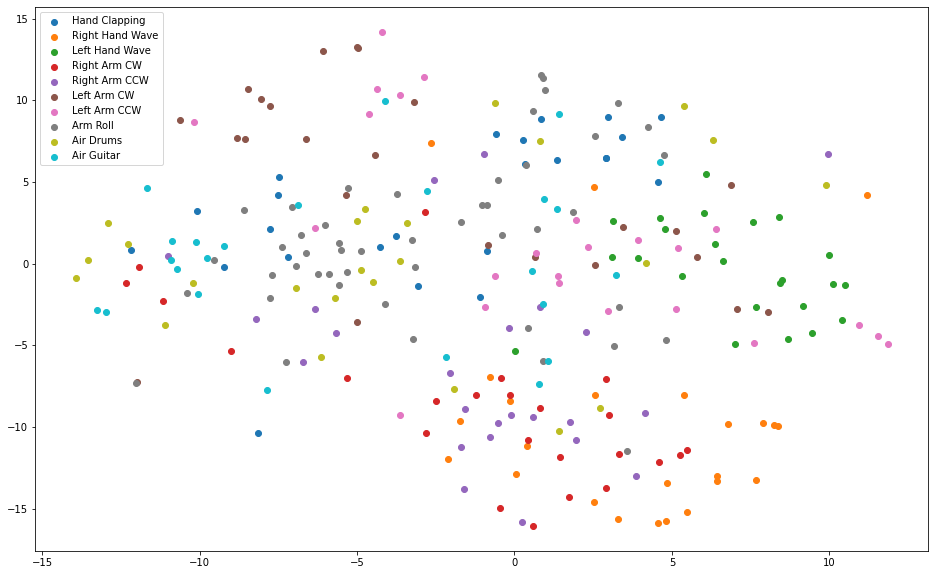

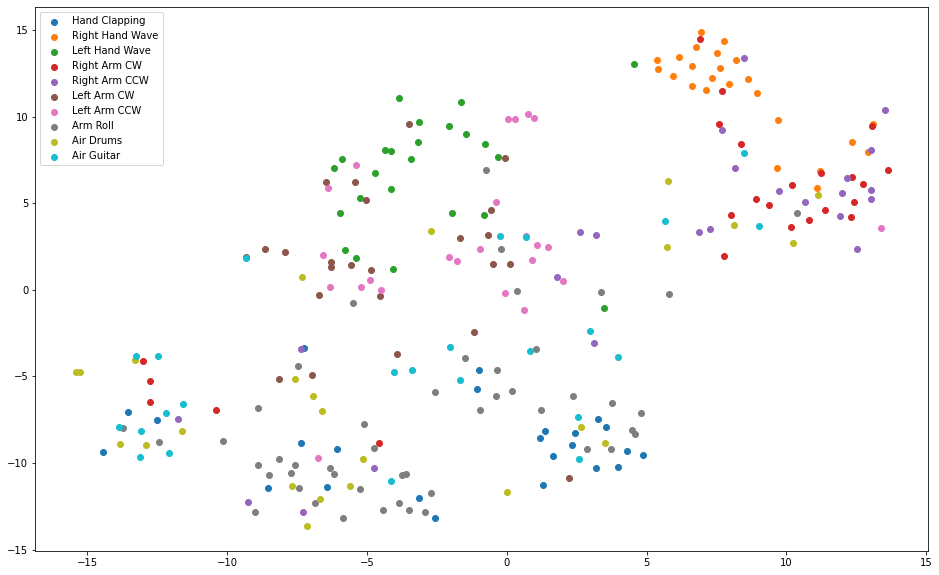

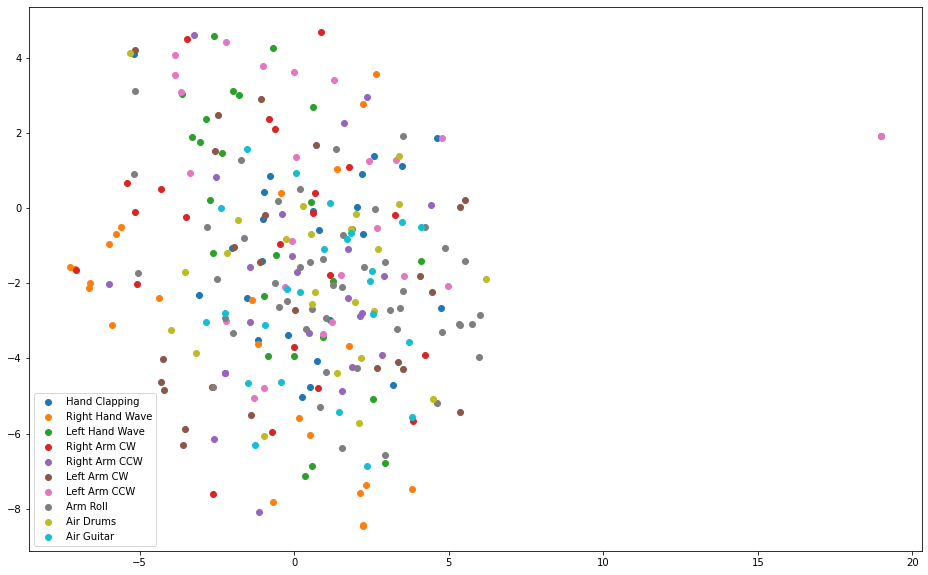

In [57]:
lat_tsne, fig, fig4, fig5 = tsne_project(lats_test, tgts_test, inhib)

In [70]:
lats, tgts = get_latent_voltage(train_dl, net)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.52it/s]


In [71]:
print(lats.shape)

(1078, 100)


In [72]:
lats_test, tgts_test = get_latent_voltage(test_dl, net)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


In [73]:
train_acc = eval_accuracy(lats, tgts, inhib, net.cls_sq)

torch.Size([1078, 10])


In [74]:
print(train_acc)

0.4267161410018553


In [75]:
test_acc = eval_accuracy(lats_test, tgts_test, inhib, net.cls_sq)

torch.Size([264, 10])


In [76]:
print(test_acc)

0.3939393939393939


In [77]:
print(lats)

[[ -4589.   3658.   7089. ...  -2003.  -6704.   -154.]
 [ -9688.   4175.  -8164. ...  -4985.  -6828.  -3063.]
 [  -543.   5705.    846. ...  -3780.  -5983.  -4157.]
 ...
 [  1103.  -8704.   9286. ...  -6387.    785.  -5455.]
 [ -1560.  -9784.   -651. ... -10344.  -2018.  -1531.]
 [  5813.  -5770.   1206. ...  -7209.  -3094.   -869.]]


In [78]:
#print(np.clip(lats,a_min=-99999,a_max=99999))

In [79]:
# note to self: need to clamp values after using reparamaterized voltage values
# could also try non reparameterized values

In [80]:
#lats = np.clip(lats,a_min=-999999,a_max=999999)

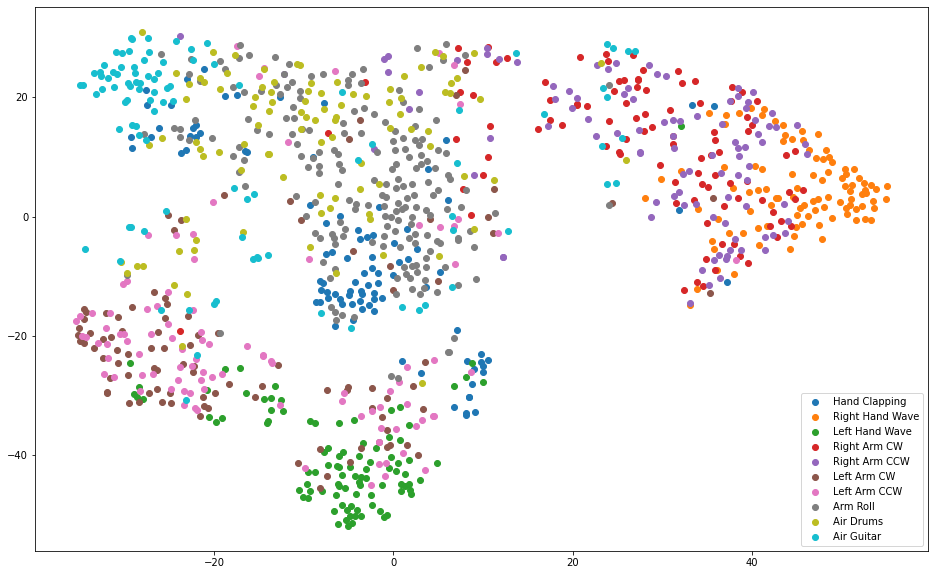

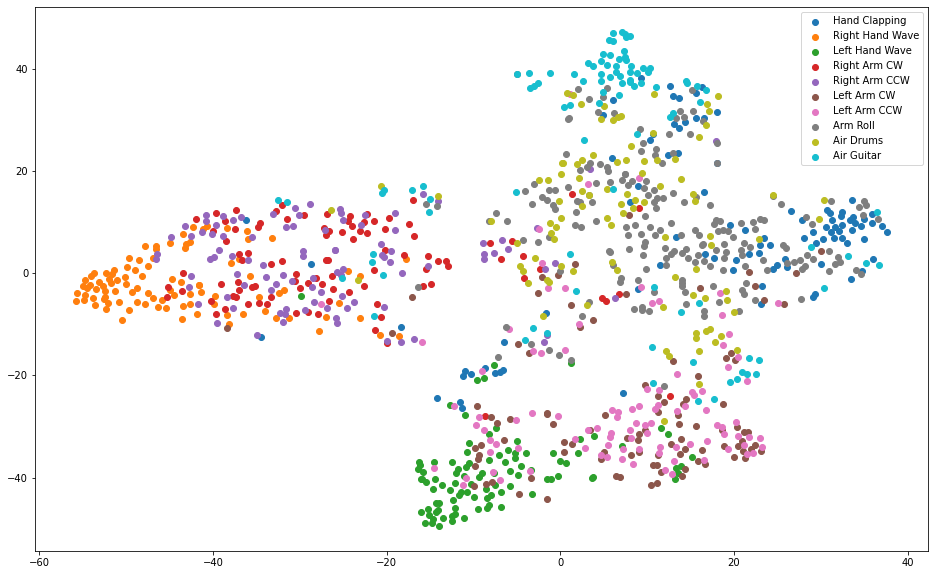

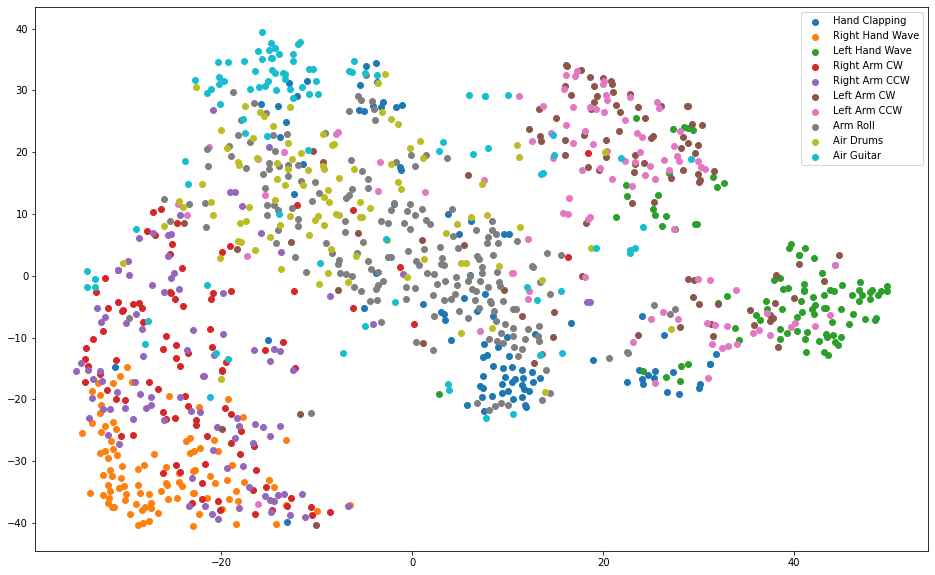

In [81]:
lat_tsne, fig, fig4, fig5 = tsne_project(lats, tgts, inhib)

## Plot the Results

In [ ]:
# Plot the results.
# Learning loss
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing .lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Learning accuracy
plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing .accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save training statistics

In [69]:
stats.save('model_weights/')

## Generate Loihi parameters
Generate Loihi parameters i.e. weight files.

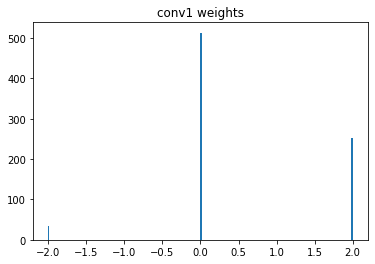

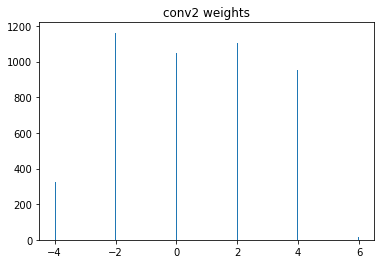

In [74]:
#net.load_state_dict(torch.load('/nmnistNet.pt'))

conv1Encoder = quantizeParams.apply(net.encoder.conv1.weight, 2).flatten().cpu().data.numpy()
conv2Encoder = quantizeParams.apply(net.encoder.conv2.weight, 2).flatten().cpu().data.numpy()
pool1Encoder = quantizeParams.apply(net.encoder.pool1.weight, 2).flatten().cpu().data.numpy()
pool2Encoder = quantizeParams.apply(net.encoder.pool2.weight, 2).flatten().cpu().data.numpy()
pool3Encoder = quantizeParams.apply(net.encoder.pool3.weight, 2).flatten().cpu().data.numpy()
fc1Encoder = quantizeParams.apply(net.encoder.fc1.weight, 2).flatten().cpu().data.numpy()
fc2Encoder = quantizeParams.apply(net.encoder.fc2.weight, 2).flatten().cpu().data.numpy()

muHead = quantizeParams.apply(net.encoder_head.fc_mu.weight, 2).flatten().cpu().data.numpy()
logvarHead = quantizeParams.apply(net.encoder_head.fc_logvar.weight, 2).flatten().cpu().data.numpy()

np.save('model_weights/VAEConv1.npy', conv1Encoder)
np.save('model_weights/VAEConv2.npy', conv2Encoder)

np.save('model_weights/VAEpool1.npy', pool1Encoder)
np.save('model_weights/VAEpool2.npy', pool2Encoder)
np.save('model_weights/VAEpool3.npy', pool3Encoder)

np.save('model_weights/VAEfc1.npy', fc1Encoder)
np.save('model_weights/VAEfc2.npy', fc2Encoder)

np.save('model_weights/Headfc_mu.npy', muHead)
np.save('model_weights/Headfc_logvar.npy', logvarHead)

plt.figure(11)
plt.hist(conv1Encoder, 256)
plt.title('conv1 weights')

plt.figure(12)
plt.hist(conv2Encoder, 256)
plt.title('conv2 weights')

plt.show()